# Exercise: Determining the extent of water bodies

## Set up notebook

### Load packages and functions

We begin this notebook with our standard set of initial configuration lines to import packages and functions we need. We also import one new function for this exercise: ```wofs_fuser```.  The ```wofs_fuser``` function is used to combine WOfS data from multiple scenes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import datacube

sys.path.append('../Scripts')
from deafrica_datahandling import load_ard, wofs_fuser
from deafrica_plotting import display_map,rgb

### Connect to the datacube

We create a new connection to the Open Data Cube, and save it into the variable ```dc```.

In [2]:
dc = datacube.Datacube(app='water_extent')

### Select area of interest

Below, we save the lat/lon extents of our area of interest into variables that we will use to load the data.  We use the 'buffer method' to define the area in terms of a center point plus or minus a buffer of 0.2 degrees.  In the previous exercie we used a single buffer variable for both latitude and longitude; this time we will define both a ```lat_buffer``` and a ```lon_buffer``` so that we can easily define a rectangular region of interest.

In [3]:
# Define the area of interest
lat = -6.0873
lon = 35.1817

lat_buffer = 0.2
lon_buffer = 0.2

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Define the year 
time = '2018'

In [4]:
display_map(lon_range, lat_range)

### Create query object

In the following cell, we create a Python dictionary and assign it to the variable ```query```.  Dictionaries are key-value stores, which means that a value stored in a dictionary can be retrieved using the key under which it was stored.  In the dictionary below, for example, we define a key called ```'x'```, and store the ```lon_range``` under that key.  Creating a dictionary to store some or all of the values that we use to load our data can help to keep our code organized, and makes it easier to reuse the parameters in subsequent loads.  Below, we will use ```query``` in two separate calls to ```load_ard``` to load two sets of data (Landsat 8 and WOfS).

In [5]:
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'output_crs':'EPSG:6933',
    'group_by':'solar_day',
    'time': time,
}

## Load data

### Load Landsat 8

Note that the following call to ```load_ard``` omits several of the parameters we're used to seeing (such as the extents and resolution).  Instead we use the ```query``` variable that we defined above.  Passing ```**query``` tells Python to send each of the values stored in the dictionary to ```load_ard``` as if we had supplied that value for the parameter identified by the corresponding key.  For example, since the ```query``` dictionary defines ```'x'``` to be ```lon_range```, it is as if we had included the usual ```x = lon_range,``` line in our call to ```load_ard```.

In [6]:
ds_landsat = load_ard(dc=dc,
                     products=['ls8_usgs_sr_scene'],
                     measurements=['red', 'green', 'blue'],
                     **query)

ds_landsat

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 44 time steps


<xarray.Dataset>
Dimensions:      (time: 44, x: 1287, y: 1693)
Coordinates:
  * x            (x) float64 3.375e+06 3.375e+06 ... 3.414e+06 3.414e+06
    spatial_ref  int32 6933
  * y            (y) float64 -7.498e+05 -7.498e+05 ... -8.005e+05 -8.005e+05
  * time         (time) datetime64[ns] 2018-01-04T07:51:05.647190 ... 2018-12...
Data variables:
    red          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    blue         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Load WOfS

For the WOfS product, we use the ```dc.load``` call.  We can also pass the ```query``` dictionary to ```dc.load```, which will reuse the same values that we used in the previous cell.

In [7]:
ds_wofs = dc.load(product=["ga_ls8c_wofs_2"],
             fuse_func=wofs_fuser,
             **query
            )

ds_wofs

<xarray.Dataset>
Dimensions:      (time: 46, x: 1287, y: 1693)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-04T07:50:41.718027 ... 2018-12...
  * y            (y) float64 -7.498e+05 -7.498e+05 ... -8.005e+05 -8.005e+05
  * x            (x) float64 3.375e+06 3.375e+06 ... 3.414e+06 3.414e+06
    spatial_ref  int32 6933
Data variables:
    water        (time, y, x) uint8 64 64 64 64 64 64 64 ... 0 64 64 64 64 64 64
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

## Calculating water extent

### Extract the water pixels

Using the table shown in the exercise, we determined that we want to examine all pixels in the WOfS product which have a value equal to 128.  We create a new variable, ```ds_valid_water```, which stores the locations of all pixels in the dataset which are equal to 128. Note this requires the double equals sign ``==``.

In [8]:
ds_valid_water = ds_wofs.water == 128

When we view the contents of the ```ds_valid_water``` variable, we can see that it contains a grid of True/False values.  Wherever ```ds_wofs.water``` was equal to 128, the array will be True.  Note that the preview below only shows a small subset of the full DataArray, and there may not be any True pixels visible in the preview output.

In [9]:
ds_valid_water

<xarray.DataArray 'water' (time: 46, y: 1693, x: 1287)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * time         (time) datetime64[ns] 2018-01-04T07:50:41.718027 ... 2018-12...
  * y            (y) float64 -7.498e+05 -7.498e+05 ... -8.005e+05 -8.005e+05
  * x            (x) float64 3.375e+06 3.375e+06 ... 3.414e+06 3.414e+06
    spatial_ref  int32 6933

### Calculate the area per pixel

We can calculate the area of a pixel by converting its resolution (which we specified in meters per pixel in our ```query``` variable's ```'resolution'``` key) into square kilometers per pixel:

In [10]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Calculate area of water pixels

Now that we know how many square kilometers a pixel represents, we can take that number and multiply it by the count of all pixels containing water in order to get the total water area in our dataset.

In [11]:
ds_valid_water_pixel_sum = ds_valid_water.sum(dim=['x', 'y'])
ds_valid_water_area = ds_valid_water_pixel_sum * area_per_pixel

## Plot Time Series

The following lines of code create a new ```figure``` which will contain a plot of our water area data, complete with custom titles, axis labels, etc.

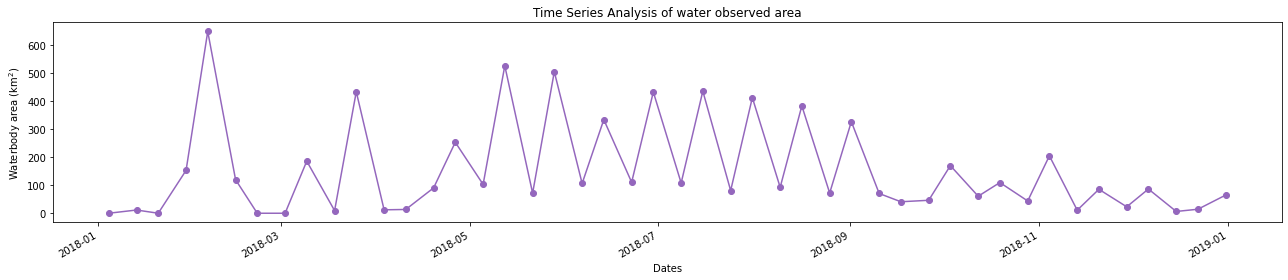

In [12]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Time Series Analysis of water observed area')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

## Display of water coverage for a selected timestep

Finally, we choose one of the times in our time series to generate more customised plots of both the Landsat and WOfS datasets.  Here we have chosen timestep ```4``` (the fifth time in the series, since we start counting at zero) but you are encouraged to experiment with other time indices to find times where the lake has dried out (the line plot above may provide some hints!).

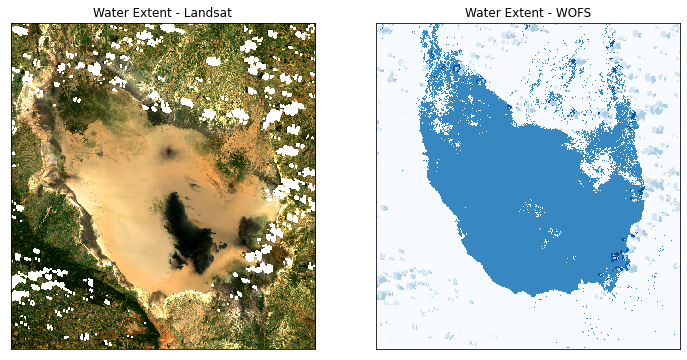

In [13]:
timestep = 4

# Plot water extent
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the true colour image
ds_nearest_landsat = ds_landsat.sel(time=ds_wofs.time.isel(time=timestep), method='nearest')
rgb(ds_nearest_landsat, ax=ax[0])

# Plot the water extent from WOfS
ds_wofs.isel(time=timestep).water.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

# Titles
ax[0].set_title("Water Extent - Landsat"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("Water Extent - WOFS"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)

plt.show()